# Линейная регрессия и основные библиотеки Python для анализа данных и научных вычислений

Используем данные [SOCR](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights) по росту и весу 25 тысяч подростков.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [2]:
data = pd.read_csv('weights_heights.csv', index_col='Index')
data.head(5)

,Height,Weight
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269
4,68.21660,142.3354
5,67.78781,144.2971


## Задание 1. Первичный анализ данных c Pandas

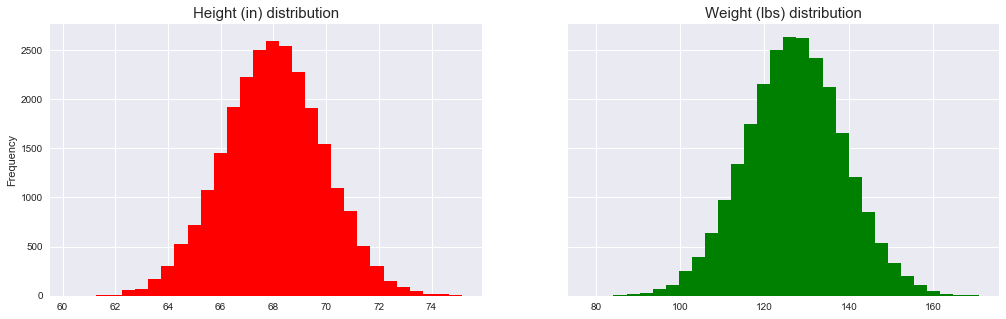

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5), sharey=True)

ax1.hist(data["Height"], color="r", bins=30)
ax1.set_title("Height (in) distribution", size=15)
ax1.set_ylabel("Frequency")

ax2.hist(data["Weight"], color="g", bins=30)
ax2.set_title("Weight (lbs) distribution", size=15);

---

Индекс массы тела:

In [4]:
def make_bmi(height_inch, weight_pound):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight_pound / KILO_TO_POUND) / \
           (height_inch / METER_TO_INCH) ** 2

In [5]:
data['BMI'] = data.apply(lambda row: make_bmi(row['Height'], 
                                              row['Weight']), axis=1)

---

Попарные зависимости признаков друг от друга:

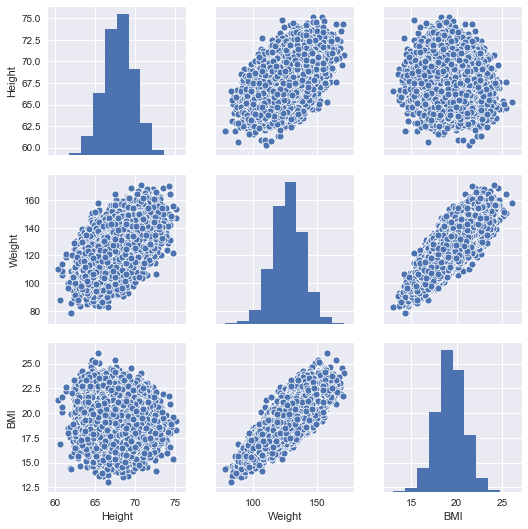

In [6]:
sns.pairplot(data);

---


Новый признак *weight_category*, имеет 3 значения:  
1 – если вес меньше 120 фунтов. (~ 54 кг.),  
3 - если вес  больше или равен 150 фунтов (~68 кг.),  
2 – в остальных случаях.

In [7]:
def weight_category(weight):
    return 1 if weight < 120 else (3 if weight > 150 else 2)

data['weight_cat'] = data['Weight'].apply(weight_category)

«Ящик с усами» показывает зависимость роста от весовой категории:

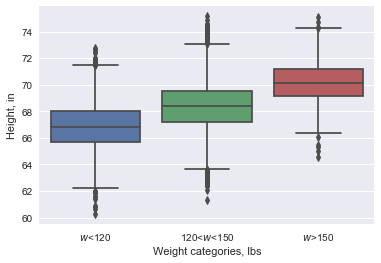

In [8]:
sns.boxplot(x="weight_cat", y="Height", data=data).set(
    xlabel="Weight categories, lbs", ylabel="Height, in")

plt.xticks(ticks=[0, 1, 2], labels=["$w$<120",
                                    "120<$w$<150",
                                    "$w$>150"]);

---

Диаграмма рассеяния зависимости роста от веса:

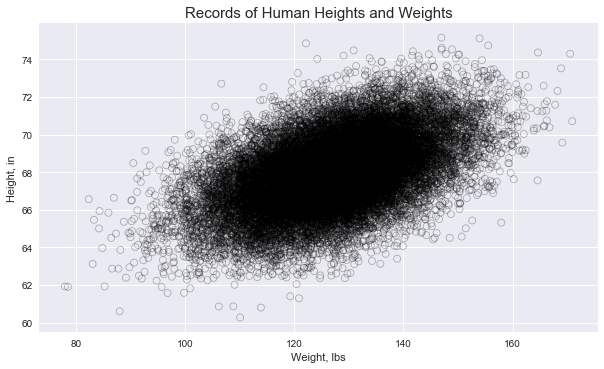

In [9]:
grid = sns.relplot(kind="scatter", x="Weight", y="Height", 
                   data=data, alpha=0.3, color="None", 
                   edgecolor="black", aspect=1.7)
grid.set_xlabels("Weight, lbs"); grid.set_ylabels("Height, in")
plt.title("Records of Human Heights and Weights", size=15);

<br>


<br>

<br>

## Задание 2. Минимизация квадратичной ошибки

Функция, которая по двум параметрам $w_0$ и $w_1$ вычисляет квадратичную ошибку приближения зависимости роста $y$ от веса $x$ прямой линией $y = w_0 + w_1 * x$:  
$$error(w_0, w_1) = \sum_{i=1}^n {(y_i - (w_0 + w_1 * x_i))}^2 $$
Здесь $n$ – число наблюдений в наборе данных, $y_i$ и $x_i$ – рост и вес $i$-ого человека в наборе данных. 

In [10]:
def err(w0:float, w1:float) ->float:
    sq_resid = (data['Height'] - (w0 + w1 * data['Weight'])) ** 2
    return sq_resid.sum()

---

Прямые, соответствующие значениям параметров ($w_0, w_1) = (60, 0.05)$ и ($w_0, w_1) = (50, 0.16)$, на графике диаграммы рассеяния:

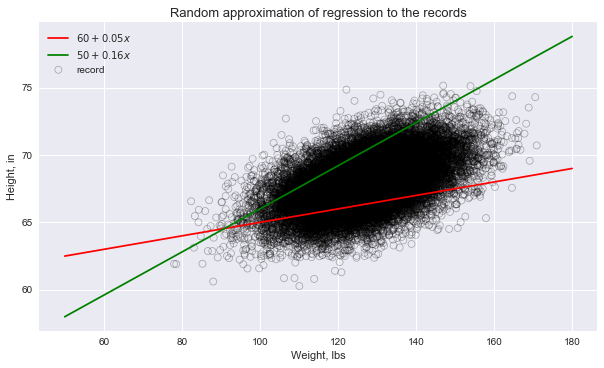

In [11]:
# старая диаграмма рассеяния
grid = sns.relplot(kind="scatter", x="Weight", y="Height", 
                   data=data, alpha=0.3, color="None", 
                   edgecolor="black", aspect=1.7)
grid.set_xlabels("Weight, lbs"); grid.set_ylabels("Height, in")
plt.title("Random approximation of regression to the records", size=13)

# произвольные попытки регрессии
x_coor = np.linspace(50, 180, 2)
y_coor1 = [60+0.05*x for x in x_coor]
y_coor2 = [50+0.16*x for x in x_coor]

plt.plot(x_coor, y_coor1, "r", x_coor, y_coor2, "g")
plt.legend(["$60+0.05x$", "$50+0.16x$", "record"]);

---

График зависимости функции ошибки <code>err</code> от параметра $w_1$ при $w_0$ = 50:

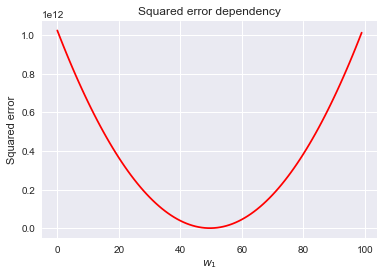

In [12]:
w0 = 50; w1_space = np.linspace(-50, 50, 100)
plt.plot([err(w0, w1) for w1 in w1_space], "r")
plt.xlabel("$w_1$"); plt.ylabel("Squared error"); plt.title("Squared error dependency");

---

Минимум функции <code>err</code> для значений параметра  $w_1$ в диапазоне [-5,5]:

In [13]:
from scipy.optimize import minimize_scalar

# minimize_scalar работает только по ОДНОМУ аргументу;
# самое близкое к mulitple dispatch, что здесь можно сделать,
# чтобы функция с 2+ аргументами стала подходящим аргументом
def err_50_instance(w1):
    return err(50, w1)


w1_opt = minimize_scalar(err_50_instance, bounds=(-5,5))
w1_opt = round(w1_opt.x,4)
print(f"При w₀=50 минимальное значение w₁={w1_opt}")

При w₀=50 минимальное значение w₁=0.1411


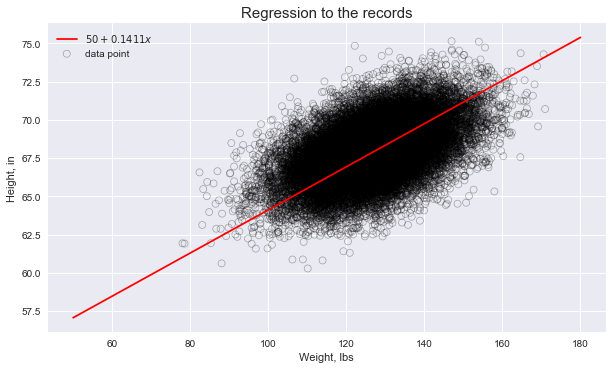

In [14]:
# старая диаграмма рассеяния
grid = sns.relplot(kind="scatter", x="Weight", y="Height", 
                   data=data, alpha=0.3, color="None", 
                   edgecolor="black", aspect=1.7)
grid.set_xlabels("Weight, lbs"); grid.set_ylabels("Height, in")
plt.title("Regression to the records", size=15)

# регрессия
y_coor3 = [50+w1_opt*x for x in x_coor]
plt.plot(x_coor, y_coor3, "r")
plt.legend([f"${w0}+{w1_opt}x$", "data point"]);

---

3D-график зависимости функции ошибки от параметров $w_0$ и $w_1$:

In [15]:
from mpl_toolkits.mplot3d import Axes3D

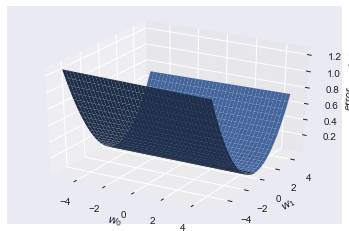

In [16]:
fig = plt.figure()
ax = fig.gca(projection='3d')

w0 = np.arange(-5, 5, 0.25)
w1 = np.arange(-5, 5, 0.25)
w0, w1 = np.meshgrid(w0, w1)

# исходная функция итерировалась средствами
# метода apply в pandas; для работы с n-векторами
# нужна «векторная» версия функции
v_err = np.vectorize(err)
error = v_err(w0, w1)

surf = ax.plot_surface(w0, w1, error)
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$')
ax.set_zlabel('error')
plt.show()

---

Минимум функции <code>err</code> для значений параметра $w_0$ в диапазоне [-100,100] и $w_1$ - в диапазоне [-5, 5]:

In [17]:
from scipy.optimize import minimize

w_opt = minimize(
                 lambda w: v_err(w[0], w[1]), 
                 x0=(0,0),
                 bounds=((-100, 100), (-5, 5)), 
                 method='L-BFGS-B'
                 ).x

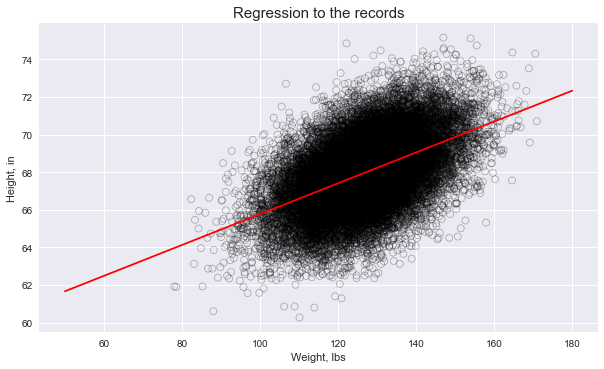

In [18]:
# старая диаграмма рассеяния
grid = sns.relplot(kind="scatter", x="Weight", y="Height", 
                   data=data, alpha=0.3, color="None", 
                   edgecolor="black", aspect=1.7)
grid.set_xlabels("Weight, lbs"); grid.set_ylabels("Height, in")
plt.title("Regression to the records", size=15)

# регрессия
y_coor4 = [w_opt[0]+w_opt[1]*x for x in x_coor]
plt.plot(x_coor, y_coor4, "r");